## Import Required Libraries :

In [16]:
from sklearn.cluster import KMeans 
#import clustering from sklearn.cluster using KMeans
from sklearn.utils import shuffle 
#import shuffle utility from sklearn utilities
import numpy as np 
#import numpy library as np
import csv 
#import csv import and export format for spreadsheets and databases
import math 
#import math library 
import matplotlib.pyplot 
#import pythons math plot library
from matplotlib import pyplot as plt 
#import plot from math plot library 
import pandas as pd 
#imports pandas methods as pd since python built-in methods can overlap panda methods.

## Pre-Processing of Human Observed Dataset : 

In [17]:
dataFrame_same = pd.read_csv('same_pairs_hu.csv') 
#read the same_pairs.csv file and put in panda series

dataFrame_diff = pd.read_csv('diffn_pairs_hu.csv') 
#read the diffn_pairs.csv file and put in panda series

dataFrame_diff_random = dataFrame_diff.sample(n=len(dataFrame_same)) 
#choose the same number of different pairs as same pairs

same_diff_one = dataFrame_same.append(dataFrame_diff_random) 
#append same and differnt

same_diff_shuffle = shuffle(same_diff_one) 
#shuffle the pandda series
 
dataFrame_human_features = pd.read_csv('HumanObserved-Features-Data.csv')
#read the HumanObserved-Features-Data.csv file and put in panda series  
    
get_features = pd.merge(same_diff_shuffle,dataFrame_human_features, how='left', left_on='img_id_A', right_on='img_id')
#merge img_id_A and img_id

get_features.drop(columns = ['Unnamed: 0','img_id'], axis=1,inplace=True) 
#drop unwanted columns 

get_features=pd.merge(get_features,dataFrame_human_features,how='left',left_on='img_id_B',right_on='img_id')
#merge img_id_B and img_id

get_features.drop(columns = ['Unnamed: 0','img_id'], axis=1,inplace=True) 
#drop unwanted columns

features_final=get_features.loc[:, ['f1_x', 'f2_x', 'f3_x', 'f4_x','f5_x', 'f6_x', 'f7_x', 'f8_x', 'f9_x', 'f1_y', 'f2_y', 'f3_y','f4_y', 'f5_y', 'f6_y', 'f7_y', 'f8_y', 'f9_y']]
#concatinate the series together



feature_target=get_features.loc[:,'target']
#select the target values from given files
print(get_features.shape)


get_hu_features =get_features

get_hu_features.drop(columns = ['img_id_A', 'img_id_B', 'target'], axis=1,inplace=True)



for i in range(0,9):
    get_hu_features['f'+ str(i+1) +'_x'] = abs(get_hu_features['f'+ str(i+1) +'_x'] - get_hu_features['f'+ str(i+1) +'_y'])

#print(get_hu_features)

get_hu_new_features = get_hu_features.iloc[:,0:9]
print(get_hu_new_features)
#print(features_final) # display the concatenated output
#print(feature_target) #display the target output


features_final.to_csv('New_Features_hu_sub.csv', index=False, header=False) 
# write the concatenated output to csv file
feature_target.to_csv('New_Target_hu_sub.csv', index=False, header=False)
# write the target output to csv file

(1582, 21)
      f1_x  f2_x  f3_x  f4_x  f5_x  f6_x  f7_x  f8_x  f9_x
0        1     1     0     0     0     1     2     3     1
1        2     0     1     1     0     2     2     1     1
2        2     0     0     0     2     0     1     1     0
3        2     1     0     2     0     1     0     2     0
4        2     0     0     0     0     1     1     1     1
5        1     0     0     0     0     1     0     3     0
6        1     3     0     3     2     0     1     0     0
7        2     0     0     3     0     1     1     0     0
8        0     0     0     1     0     0     1     2     1
9        2     0     0     1     0     1     0     0     0
10       0     1     0     3     0     1     0     0     0
11       2     0     0     1     0     0     0     1     1
12       1     0     1     1     0     1     3     2     0
13       2     3     1     1     0     1     2     2     0
14       1     1     0     2     2     1     1     0     0
15       2     0     0     3     0     1     

## Initialize Different Parameters & Functions : 

In [18]:
maxAcc = 0.0 
#initialize Max Accurary = 0.0 

maxIter = 0 
#initialize Max Iterations = 0

C_Lambda = 10 
#initialize Lambda value

TrainingPercent = 80 
#initialize Training Data Set % = 80

ValidationPercent = 10 
#initialize Validation Data Set % = 10

TestPercent = 10 
#initialize Test Data Set % = 10 

M = 6 
#initialize number of M Basis Functions = 10

PHI = [] 
#initialize PHI as an Array 

IsSynthetic = False 
#set IsSynthetic value as False

## Calculation for Linear Regression :

In [19]:
def GetTargetVector(filePath):                         #define GetTarget Vector code block with source filePath
    t = []                                             #define target vector array
    with open(filePath, 'rU') as f:                    #open or set directory for the source filePath as f
        reader = csv.reader(f)                         #open filePath defined as f in csv reader 
        for row in reader:                             #from the filepath access rows 
            t.append(int(row[0]))                      #append row values to target array
    return t                                           #return the values to target dataset t

def GenerateRawData(filePath, IsSynthetic): 
                                 #define GenerateRawData with source filePath and IsSynthetic value set as False    
    dataMatrix = []              #define dataMatrix as an array to store values
    with open(filePath, 'rU') as fi: #open or set directory for the source filePath as fi
        reader = csv.reader(fi)      #open filePath defined as fi in csv reader
        for row in reader:           #from the filepath access rows
            dataRow = []             #dataRow array saves the values
            for column in row: #for every column in datarow
                dataRow.append(float(column)) #append the value of dataRow as float
            dataMatrix.append(dataRow)        #append the dataRow matrix in dataMatrix   
    
    if IsSynthetic == False : 
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) # delete array elements from dataMatrix 
    dataMatrix = np.transpose(dataMatrix)                       # take the transpose of the dataMatrix     
    return dataMatrix                                  #return the dataMatrix which was transposed in above line

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80): 
                                                    #define GenerateTrainingTarget data with data and percentage
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01))) 
                                                   #covert to float and put the values in TrainingLen
    t           = rawTraining[:TrainingLen]        #put the values of rawTraining set into target vector array t
                                                 
    return t                                       #return new target vector array t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80): 
                                                  #define GenerateTrainingDataMatrix with rawData and percentage
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
                                                  #covert to float and put the values in T_Len
    d2 = rawData[:,0:T_len]                       #put values in d2 
    return d2                                     #return d2 with changes

def GenerateValData(rawData, ValPercent, TrainingCount): 
                                              #define GenerateValData with rawData, TrainingCount and ValPercent 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01)) #calculate val_size with float values
    V_End = TrainingCount + valSize 
    dataMatrix = rawData[:,TrainingCount+1:V_End]             #update the dataMatrix with new values 
    return dataMatrix                                         #return the updated dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
                                                               #define GenerateValTargetVector for taget vectors 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))     #calculate val_size with float values
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]                          #update the target Vector values with new values
    return t                                                   #return the updated array t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic): 
                                                               #define GenerateBigSigma for traning Vectors
    BigSigma    = np.zeros((len(Data),len(Data)))              #BigSigma takes the values of the Data
    DataT       = np.transpose(Data)                           #take the transpose of the Data Matrix 
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) #calculate Training Lenth with float values       
    varVect     = [] 
    for i in range(0,len(DataT[0])):                           #iterate the values for tranpose data range
        vct = []
        for j in range(0,int(TrainingLen)):                    #iterate the values for TrainingLen range
            vct.append(Data[i][j])                             #append the values in array vct 
        varVect.append(np.var(vct))                            #append the values in array varVect
    
    for j in range(len(Data)):                                 #iterate the values for data range
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:                                    #if value True
        BigSigma = np.dot(3,BigSigma)                          #calculate BigSigma
    else: #if value False
        BigSigma = np.dot(200,BigSigma)                        #calculate BigSigma
    return BigSigma                                            #return the updated value of the BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):                       #define the GetScalar
    R = np.subtract(DataRow,MuRow)                             #calculate R
    T = np.dot(BigSigInv,np.transpose(R))                      #calculate T   
    L = np.dot(R,T)                                            #calculate L
    return L                                                   #return the updated value of L 

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):               #define the RadialBasis function    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv)) 
    return phi_x                                               #return the update value of phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80): #define the Phi Matrix 
    DataT = np.transpose(Data)                                    #take the transpose of DataT matrix
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))    #calculate TraningLen with float values         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix)))              #take the required PHI values
    BigSigInv = np.linalg.inv(BigSigma)                           #calculate the BigSigma inverse value
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) #calculate the PHI values
    return PHI                                                              #return updated PHI values

def GetWeightsClosedForm(PHI, T, Lambda):                                    #define the GetWeightsCLosedForm
    Lambda_I = np.identity(len(PHI[0]))                                      #Lamda_I = identity matrix of PHI
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)                                          #calculate phi transpose
    PHI_SQR     = np.dot(PHI_T,PHI)                                          #calculate phiT.phi
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)                                   #calculate lambda + phiT.phi
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)                                  #calculate phi inverse
    INTER       = np.dot(PHI_SQR_INV, PHI_T)              #calculate dot product of phi inverse and transpose
    W           = np.dot(INTER, T)                                           #calculate w
    return W                                                                 #return the updated value of w

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):  #define the GetPhiMatrix
    DataT = np.transpose(Data)                                     #transpose of DataT
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))     #calculate TraningLen with float values         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix)))               #Phi matrix  
    BigSigInv = np.linalg.inv(BigSigma)                            #calculate the BigSigma Inverse
    for  C in range(0,len(MuMatrix)): 
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) 
                                                                      #for each range of Mu Matrix calculate phi
    return PHI                                                        #return the updated values of Phi

def GetValTest(VAL_PHI,W):                                            #define GetValTest for validation
    Y = np.dot(W,np.transpose(VAL_PHI))                               #calculate W . ValPhi
    return Y                                                          #return the update values of Y

def GetErms(VAL_TEST_OUT,ValDataAct):                                 #define the GetERMS block
    sum = 0.0                                                         #initialize sum = 0.0
    t=0                                                               #initialize t = 0 for target vectors
    accuracy = 0.0                                                    #initialize accuracy = 0.0
    counter = 0                                                       #initialize counter to 0
    val = 0.0                                                         #initialize val to 0
    for i in range (0,len(VAL_TEST_OUT)): 
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)     #calculate the sum
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1                                                #increment the counter
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))        #calculate the accuracy of the data
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT)))) # return the value of ERMS

## Fetch and Prepare Dataset

In [20]:
RawTarget = GetTargetVector('New_Target_hu.csv')              #feed the machine the target ouput csv file
RawData   = GenerateRawData('New_Features_hu.csv',IsSynthetic)#feed the machine the concatenated output csv file

C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\NEERAJ\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


## Prepare Training Data

In [21]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent)) #give traning target data
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)         #give training data from matrix

print(TrainingTarget.shape) 
print(TrainingData.shape)

(1266,)
(13, 1266)


## Prepare Validation Data

In [22]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget)))) 
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget))) 
#give the validation data with generated data

print(ValDataAct.shape)
print(ValData.shape)

(158,)
(13, 158)


## Prepare Test Data

In [23]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct))) #give test data 

print(ValDataAct.shape)
print(ValData.shape)

(158,)
(13, 158)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [24]:
ErmsArr = []                  
#define the Erms array

AccuracyArr = []              
#define accuracy array

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) 
#calculate the clustering using KMeans

Mu = kmeans.cluster_centers_  
#calculate the Mu value

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)   
#calculate the BigSigma value

TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)         
#calculate the traning phi value

W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
#calculate the regularizer value

TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
#get the Test phi value

VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100) 
#get the val phi value

In [25]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(6, 13)
(13, 13)
(1266, 6)
(6,)
(158, 6)
(157, 6)


## Finding Erms on Training, Validation and Test set 

In [26]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W) 
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget)) #get erms of training data accuracy
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))    #get erms of validation data accuracy
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))       #get erms of test data accuracy


In [27]:
print ('UBITname      = nabhyank')
print ('Person Number = 50290958')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = " + str (M))
print ("Lambda = " + str(C_Lambda))
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("Traning Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("Validation Accuracy   = " + str(float(ValidationAccuracy.split(',')[0])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
print ("Testing Accuracy   = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = nabhyank
Person Number = 50290958
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 6
Lambda = 10
E_rms Training   = 0.4994297297344306
Traning Accuracy   = 51.18483412322275
E_rms Validation = 0.5009793594327165
Validation Accuracy   = 44.30379746835443
E_rms Testing    = 0.5004259858379453
Testing Accuracy   = 45.22292993630573


## Gradient Descent solution for Linear Regression

In [28]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [29]:
W_Now        = np.dot(220, W)                                        #take the dot product to calculate W now 
La           = 10                                                     #initialize Lambda value
learningRate = 0.01                                                  #set the learning rate value
L_Erms_Val   = []                                                    #define Erms value of validation data array
L_Erms_Acc_Val   = []                                                #define Erms value of accuracy data array
L_Erms_TR    = []                                                    #define Erms value of training data array
L_Erms_Acc_TR   = []                                                 #define Erms value of accuracy data array
L_Erms_Test  = []                                                    #define Erms value of testing data array
L_Erms_Acc_Test   = []                                               #define Erms value of accuracy data array
W_Mat        = []                                                    #define W

for i in range(0,400):                                               #iterate for range of 40 
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i]) 
    #calculate change in E_D
    La_Delta_E_W  = np.dot(La,W_Now) 
    #calculate change in E_W dot product with lambda
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W) 
    #calculate change in E    
    Delta_W       = -np.dot(learningRate,Delta_E) 
    #change in W is negative of dot product of learning rate and change in E  
    W_T_Next      = W_Now + Delta_W 
    #next W = current w + change in W
    W_Now         = W_T_Next 
    #update current W to next W where W is the weight
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget) 
    #calculate the erms training accuracy for all weights and phi values
    L_Erms_TR.append(float(Erms_TR.split(',')[1])) 
    #append the values acquired in above calculation
    L_Erms_Acc_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct) 
    #calculate the erms validation accuracy for all values of testing set and actual data values
    L_Erms_Val.append(float(Erms_Val.split(',')[1])) 
    #append the values acquired in above calculation
    L_Erms_Acc_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct) 
    #calculate the erms testing accuracy 
    L_Erms_Test.append(float(Erms_Test.split(',')[1])) 
    #append the values from above calculation
    L_Erms_Acc_Test.append(float(Erms_Test.split(',')[0])) 
    #append the values from above calculation

----------Gradient Descent Solution--------------------
M = 6
La = 10
Learning Rate = 0.01
E_rms Training   = 0.49938
Traning Accuracy   = 51.18483
E_rms Validation = 0.49765
Validation Accuracy   = 55.06329
E_rms Testing    = 0.49731
Testing Accuracy   = 51.18483


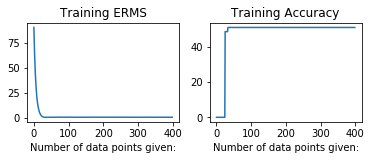

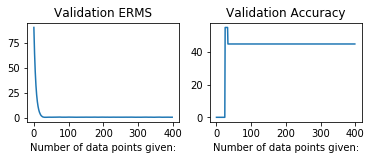

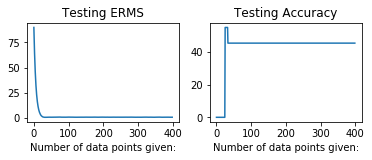

In [30]:
print ('----------Gradient Descent Solution--------------------')
print ("M = "+ str (M))
print ("La = "+ str(La))
print ("Learning Rate = "+ str(learningRate))
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("Traning Accuracy   = " + str(np.around(max(L_Erms_Acc_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("Validation Accuracy   = " + str(np.around(max(L_Erms_Acc_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Testing Accuracy   = " + str(np.around(max(L_Erms_Acc_TR),5)))

plt.figure(1)
plt.subplot(2,2,1)
plt.plot(L_Erms_TR)
plt.title('Training ERMS')
plt.xlabel('Number of data points given:')

plt.subplot(2,2,2)
plt.plot(L_Erms_Acc_TR)
plt.title('Training Accuracy')
plt.xlabel('Number of data points given:')

plt.figure(2)
plt.subplot(2,2,1)
plt.plot(L_Erms_Val)
plt.title('Validation ERMS')
plt.xlabel('Number of data points given:')

plt.subplot(2,2,2)
plt.plot(L_Erms_Acc_Val)
plt.title('Validation Accuracy')
plt.xlabel('Number of data points given:')

plt.figure(3)
plt.subplot(2,2,1)
plt.plot(L_Erms_Test)
plt.title('Testing ERMS')
plt.xlabel('Number of data points given:')

plt.subplot(2,2,2)
plt.plot(L_Erms_Acc_Test)
plt.title('Testing Accuracy')
plt.xlabel('Number of data points given:')

plt.show()